In [44]:
import pandas as pd
import numpy as np
from pprint import pprint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
from tensorflow import keras
from keras import layers, Sequential

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [3]:
le = preprocessing.LabelEncoder()
yes_df_emb = pd.read_csv('data/yes_emotion.csv')

label = le.fit_transform(yes_df_emb['sentiment'].values)
corpus = yes_df_emb['content'].values


sentences_train, sentences_test, y_train, y_test = train_test_split(
                                    corpus, label, test_size=0.25, random_state=1000)


In [4]:
vectorizer = CountVectorizer(strip_accents = "ascii", stop_words='english')
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

X_test = X_test.sorted_indices()
X_train = X_train.sorted_indices()

classifier = LogisticRegression(max_iter=500)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print(f'Accuracy for yes_emb data: {score*100}%')

Accuracy for yes_emb data: 34.150000000000006%


In [5]:
input_dim = X_train.shape[1] 

model = Sequential()
model.add(layers.Dense(10, input_dim = input_dim, activation = 'relu'))
model.add(layers.Dense(13, input_dim = input_dim, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy',
                optimizer = 'adam',
                metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                390520    
_________________________________________________________________
dense_1 (Dense)              (None, 13)                143       
Total params: 390,663
Trainable params: 390,663
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(X_train, y_train,
                    epochs = 10,
                    verbose=True,
                    validation_data=(X_test,y_test),
                    batch_size=126)

Epoch 1/10
239/239 [==============================] - 1s 3ms/step - loss: 2.4498 - accuracy: 0.1488 - val_loss: 2.1168 - val_accuracy: 0.2760
Epoch 2/10
239/239 [==============================] - 0s 2ms/step - loss: 1.9998 - accuracy: 0.3534 - val_loss: 1.9978 - val_accuracy: 0.3333
Epoch 3/10
239/239 [==============================] - 0s 2ms/step - loss: 1.7869 - accuracy: 0.4429 - val_loss: 1.9521 - val_accuracy: 0.3482
Epoch 4/10
239/239 [==============================] - 0s 2ms/step - loss: 1.5898 - accuracy: 0.5048 - val_loss: 1.9416 - val_accuracy: 0.3484
Epoch 5/10
239/239 [==============================] - 0s 2ms/step - loss: 1.4200 - accuracy: 0.5610 - val_loss: 1.9536 - val_accuracy: 0.3466
Epoch 6/10
239/239 [==============================] - 0s 2ms/step - loss: 1.2268 - accuracy: 0.6380 - val_loss: 1.9778 - val_accuracy: 0.3451
Epoch 7/10
239/239 [==============================] - 0s 2ms/step - loss: 1.0715 - accuracy: 0.6963 - val_loss: 2.0150 - val_accuracy: 0.3389
Epoch 

In [7]:
clear_session()

In [8]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8501
Testing Accuracy:  0.3257


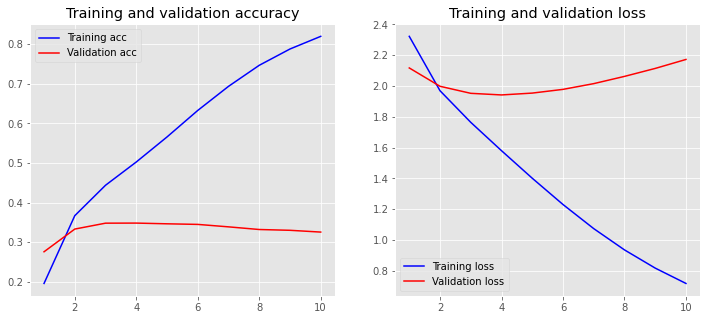

In [9]:
plot_history(history)

In [10]:
tokenizer = Tokenizer(num_words=5000,filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[4])
print(X_train[2])

@halbpro it's called retro my dear and I wear fifties fashion sometimes....did you not see my birthday pictures?
[4, 121, 1029, 144]


In [11]:
maxlen = max(yes_df_emb['content'].apply(str.split).apply(len))

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])
pprint(maxlen)

[4535   52  620    2  979    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
34


In [12]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(layers.Dense(13, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 50)            2400300   
_________________________________________________________________
flatten (Flatten)            (None, 1700)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               170100    
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1313      
Total params: 2,571,713
Trainable params: 2,571,713
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=126)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))



Epoch 1/10
239/239 [==============================] - 5s 19ms/step - loss: 2.1822 - accuracy: 0.2448 - val_loss: 2.0005 - val_accuracy: 0.3081
Epoch 2/10
239/239 [==============================] - 4s 19ms/step - loss: 1.8865 - accuracy: 0.3633 - val_loss: 1.9426 - val_accuracy: 0.3315
Epoch 3/10
239/239 [==============================] - 4s 18ms/step - loss: 1.6703 - accuracy: 0.4523 - val_loss: 1.9836 - val_accuracy: 0.3291
Epoch 4/10
239/239 [==============================] - 4s 17ms/step - loss: 1.3636 - accuracy: 0.5695 - val_loss: 2.1672 - val_accuracy: 0.3092
Epoch 5/10
239/239 [==============================] - 4s 17ms/step - loss: 1.0283 - accuracy: 0.6914 - val_loss: 2.4614 - val_accuracy: 0.2938
Epoch 6/10
239/239 [==============================] - 4s 18ms/step - loss: 0.7509 - accuracy: 0.7846 - val_loss: 2.7844 - val_accuracy: 0.2797
Epoch 7/10
239/239 [==============================] - 4s 18ms/step - loss: 0.5606 - accuracy: 0.8439 - val_loss: 3.1580 - val_accuracy: 0.2717

In [14]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9448
Testing Accuracy:  0.2529


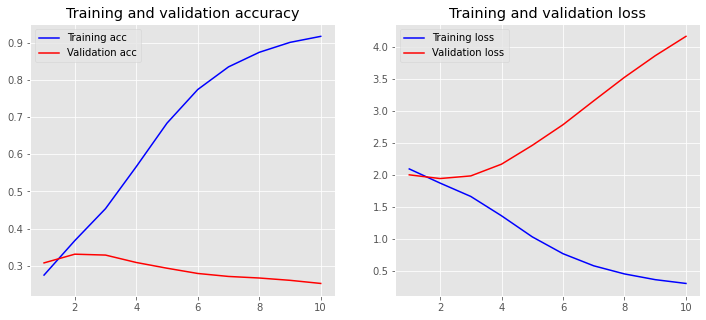

In [15]:
plot_history(history)

In [16]:
pprint(model.layers)
emb_layer = model.layers[0]
pprint(emb_layer.get_weights())

[array([[-0.00618006,  0.00245844, -0.0103912 , ...,  0.00560357,
        -0.00858277,  0.00720124],
       [ 0.0102115 , -0.01444776, -0.00171417, ...,  0.05035562,
         0.00818125, -0.00747643],
       [-0.03170178, -0.01339143,  0.00790158, ..., -0.03060921,
         0.02382185, -0.04556876],
       ...,
       [ 0.03115653,  0.02613551, -0.01664861, ...,  0.01693355,
        -0.03764341, -0.00052726],
       [-0.04976232,  0.0259923 ,  0.03693462, ...,  0.01588049,
         0.03340591, -0.00256556],
       [ 0.01958002, -0.01598694, -0.04013821, ...,  0.04918257,
        -0.00749973, -0.03508544]], dtype=float32)]


In [43]:
print(X_test.shape)

y_pred = model.predict(X_test, batch_size=64, verbose = 1)
print(classification_report(y_test,y_pred.argmax(1), target_names = np.unique(yes_df_emb["sentiment"])))


(10000, 34)
157/157 [==============================] - 0s 604us/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        27
     boredom       0.08      0.02      0.04        44
       empty       0.05      0.03      0.04       203
  enthusiasm       0.02      0.01      0.01       202
         fun       0.08      0.06      0.07       450
   happiness       0.24      0.26      0.25      1290
        hate       0.19      0.16      0.17       340
        love       0.32      0.27      0.29       949
     neutral       0.32      0.35      0.33      2166
      relief       0.09      0.09      0.09       382
     sadness       0.23      0.23      0.23      1296
    surprise       0.12      0.10      0.11       549
       worry       0.29      0.34      0.31      2102

    accuracy                           0.25     10000
   macro avg       0.16      0.15      0.15     10000
weighted avg       0.24      0.25      0.25     10000

/home/josh

In [106]:
def predict_emo(model, text):
    #text = text.split()
    tokenizer = Tokenizer(num_words=500)
    tokenizer.fit_on_texts(text)
    text_token = tokenizer.texts_to_sequences(text)
    #vocab_size = len(tokenizer.word_index) + 1 
    x_text = pad_sequences(text_token, padding='post', maxlen=maxlen)
    y_pred = model.predict(x_text)
    emo = np.argmax(y_pred[0])
    liste_emotion = ['boredom','empty','enthusiasm','fun', 'happiness','hate','love','neutral','relief','sadness','surprise', 'worry','anger']
    emotion = liste_emotion[emo]
    return emotion

text = "I am very happy"
predict_emo(model, text)

'relief'